In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATASET_PATH = '/home/ayagudin/dl/probabilistic-time-series/lobster-preprocessed-dataset/'

In [4]:
from data_utils import load_features_and_targets

In [5]:
features_per_day, targets_per_day = load_features_and_targets(DATASET_PATH)

# Cut session begin & end
> TODO reconstruct dataset so that it will have only moments with huge traded_amount

In [6]:
timestamps_to_cut = 200

In [7]:
for day in features_per_day:
    features_per_day[day] = features_per_day[day][timestamps_to_cut:-timestamps_to_cut]
    targets_per_day[day] = targets_per_day[day][timestamps_to_cut:-timestamps_to_cut].reshape(-1, 1)

In [8]:
full_features = np.concatenate(list(features_per_day.values()))
full_targets = np.concatenate(list(targets_per_day.values()))
full_features.shape, full_targets.shape

((926340, 27), (926340, 1))

# Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
target_scaler = StandardScaler()
feature_scaler = StandardScaler()

In [11]:
feature_scaler.fit(full_features)
target_scaler.fit(full_targets)

StandardScaler()

In [12]:
for day in features_per_day:
    features_per_day[day] = feature_scaler.transform(features_per_day[day])
    targets_per_day[day] = target_scaler.transform(targets_per_day[day]).reshape(-1)

# Defining dataset

In [22]:
dataset_metadata = {
    'freq': '1H',
 'prediction_length': 1,
 'features_history': 10,
 'start': pd.Timestamp('2019-01-01 00:00:00', freq='H'),
 'num_train_days': 14,
 'num_test_days': 3}


In [24]:
days = sorted(list(features_per_day.keys()))
train_days = days[:dataset_metadata['num_train_days']]
test_days = days[dataset_metadata['num_train_days']:]
print(len(train_days), len(test_days))

14 6


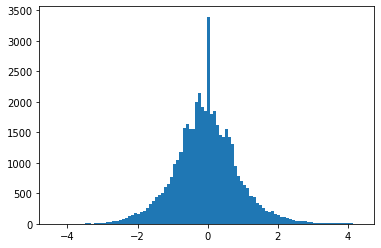

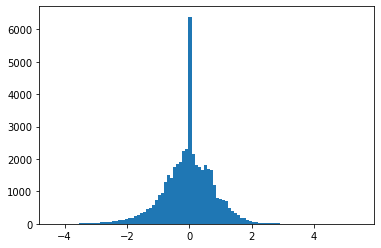

In [25]:
plt.hist(targets_per_day[days[-1]], bins=100);
plt.show()
plt.hist(targets_per_day[days[0]], bins=100);
plt.show()

In [26]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [27]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: targets_per_day[day],
            FieldName.START: dataset_metadata['start'],
            FieldName.FEAT_DYNAMIC_REAL: features_per_day[day].T
        }
        for day in train_days
    ],
    freq=dataset_metadata['freq']
)

# for test_ds we had to create a list of dicts 
# with all suffixes from test_days

# MLP Regression

In [28]:
# from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
# from gluonts.mx import Trainer
# from gluonts.evaluation import Evaluator

In [229]:
# estimator = SimpleFeedForwardEstimator(
#     num_hidden_dimensions=[10],
#     prediction_length=1,
#     context_length=10,
#     freq=dataset_metadata['freq'],
#     trainer=Trainer(
#         ctx="cpu",
#         epochs=5,
#         learning_rate=1e-3,
#         hybridize=False,
#         num_batches_per_epoch=100
#     )
# )

In [168]:
# predictor = estimator.train(train_ds)

100%|██████████████████████████████████████████████| 100/100 [00:05<00:00, 17.37it/s, epoch=5/5, avg_epoch_loss=-1.52]


In [ ]:
# evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

# MLP Uncertainty estimation

In [29]:
# from pts.model.simple_feedforward import SimpleFeedForwardTrainingNetwork
# from pts.model.simple_feedforward import SimpleFeedForwardEstimator
from models.simple_feedforward_estimator import SimpleFeedForwardEstimator
from models.simple_feedforward_network import SimpleFeedForwardTrainingNetwork
from pts import Trainer
import torch

from gluonts.mx import DistributionOutput, GaussianOutput

from pts.modules import NormalOutput


In [30]:

device = torch.device("cpu")

estimator = SimpleFeedForwardEstimator(
    prediction_length=dataset_metadata['prediction_length'] + 1,
    context_length=dataset_metadata['features_history'],
    freq=dataset_metadata['freq'],
    num_hidden_dimensions=[324, 40, 40, 1],
    # distr_output=NormalOutput(),
    trainer=Trainer(
        device=device,
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [31]:
estimator.create_training_network(device).mlp

Sequential(
  (0): Linear(in_features=324, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=2, bias=True)
  (5): LambdaLayer()
)

In [32]:
predictor = estimator.train(train_ds)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

# Validation

In [33]:
from gluonts.evaluation import make_evaluation_predictions

In [ ]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: targets_per_day[day],
            FieldName.START: dataset_metadata['start'],
            FieldName.FEAT_DYNAMIC_REAL: features_per_day[day].T
        }
        for day in test_days
    ],
    freq=dataset_metadata['freq']
)

In [34]:
forecast_it_tmp, ts_it_tmp = make_evaluation_predictions(
    dataset=train_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [35]:
forecasts_tmp = list(forecast_it_tmp)
tss_tmp = list(ts_it_tmp)

In [36]:
# first entry of the time series list
ts_entry = tss_tmp[0]

In [37]:
np.array(ts_entry[:5]).reshape(-1,)

array([2.0867705, 2.1344833, 2.1726534, 0.6744707, 0.7030984],
      dtype=float32)

In [38]:
test_ds_entry = next(iter(train_ds))

In [39]:
test_ds_entry['target'][:5]

array([2.0867705, 2.1344833, 2.1726534, 0.6744707, 0.7030984],
      dtype=float32)

In [41]:
forecast_entry = forecasts_tmp[0]

In [42]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 2)
Start date of the forecast window: 2024-04-13 19:00:00
Frequency of the time series: 1H


In [43]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 10
    prediction_intervals = (50, 90)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

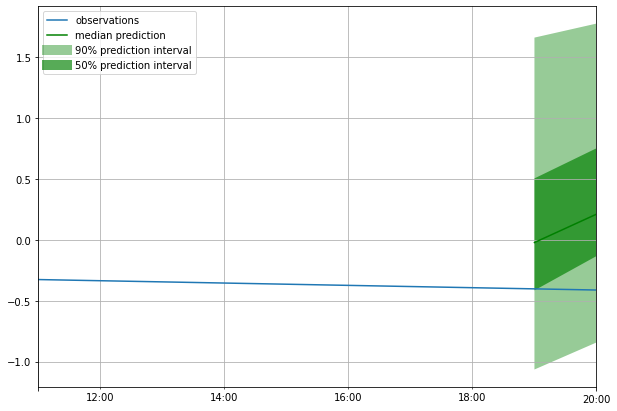

In [44]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
# https://github.com/zalandoresearch/pytorch-ts/issues/24

In [54]:
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from pandas import Timedelta

In [69]:
def get_rolled_dataset(dataset, context_length, prediction_length):
    keys_to_split = [
        FieldName.FEAT_DYNAMIC_REAL,
        FieldName.TARGET
    ]
    window_size = context_length + prediction_length
    
    rolled_dataset = []
    
    for dataset_entry in tqdm(iter(dataset)):
        for i in range(len(dataset_entry[FieldName.TARGET]) - window_size):
            new_entry = {}
            for key in dataset_entry.keys():
                if key not in keys_to_split:
                    new_entry[key] = dataset_entry[key]
                else:
                    new_entry[key] = dataset_entry[key][..., i: i + window_size]
                    
            new_entry[FieldName.START] = dataset_entry[FieldName.START] + Timedelta(dataset_metadata['freq']) * i
            
            rolled_dataset.append(new_entry)
    
    return ListDataset(rolled_dataset, freq=dataset_metadata['freq'])
            

In [70]:
train_ds_rolled = get_rolled_dataset(train_ds, 
                                     context_length=dataset_metadata['features_history'], 
                                     prediction_length=dataset_metadata['prediction_length'] + 1)

0it [00:00, ?it/s]

In [71]:
len(train_ds_rolled)

648270

In [72]:
rolled_train_entry = next(iter(train_ds_rolled))

In [73]:
rolled_train_entry['target'].shape, rolled_train_entry['feat_dynamic_real'].shape

((12,), (27, 12))

In [74]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds_rolled,  # test dataset
    predictor=predictor,  # predictor
    num_samples=10,  # number of sample paths we want for evaluation
)

In [75]:
forecasts = list(forecast_it)
tss = list(ts_it)

# Train Metrics

In [76]:
from gluonts.evaluation import Evaluator

In [77]:
# actually we can easily calculate it by hand
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), 
                                      iter(forecasts), 
                                      num_series=len(train_ds_rolled))

Running evaluation: 100%|██████████████████████████████████████████████████| 648270/648270 [00:15<00:00, 42488.62it/s]/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error

/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered 

In [78]:
# print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
agg_metrics

{'MSE': 1.1656175427263293,
 'abs_error': 994215.4132566983,
 'abs_target_sum': 906895.1489986305,
 'abs_target_mean': 0.6994733282418055,
 'seasonal_error': 0.06556432461425392,
 'MASE': inf,
 'MAPE': 5.126774052029617,
 'sMAPE': 1.5371755468908275,
 'MSIS': inf,
 'QuantileLoss[0.1]': 519125.8079424667,
 'Coverage[0.1]': 0.1784580498866213,
 'QuantileLoss[0.5]': 994215.4132733995,
 'Coverage[0.5]': 0.4526917796597097,
 'QuantileLoss[0.9]': 556490.9165817369,
 'Coverage[0.9]': 0.8143520446727444,
 'RMSE': 1.0796376904898835,
 'NRMSE': 1.5435008697238795,
 'ND': 1.0962848509604275,
 'wQuantileLoss[0.1]': 0.5724209777896283,
 'wQuantileLoss[0.5]': 1.0962848509788432,
 'wQuantileLoss[0.9]': 0.6136221118794156,
 'mean_absolute_QuantileLoss': 689944.0459325343,
 'mean_wQuantileLoss': 0.7607759802159624,
 'MAE_Coverage': 0.07047140851805576,
 'OWA': nan}

In [79]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,1.192913,2.692346,1.215345,0.607673,0.312784,4.303842,2.230852,2.000000,16.145861,1.195561,0.0,2.692346,0.0,0.300830,1.0
1,NaN,4.702199,5.113446,1.310771,0.655386,0.312254,8.187961,3.941091,2.000000,16.945952,1.647493,0.0,5.113446,0.0,1.034210,0.5
2,NaN,1.489569,3.061969,1.019723,0.509861,0.313314,4.886420,4.085718,1.703297,24.377159,1.444575,0.0,3.061969,0.0,0.463899,1.0
3,NaN,1.982828,3.208847,1.496851,0.748426,0.152151,10.544950,2.654720,2.000000,30.782852,1.197043,0.0,3.208847,0.0,0.252262,1.0
4,NaN,4.694784,4.598998,2.365225,1.182612,0.186610,12.322474,1.955956,2.000000,114.593813,1.323465,0.0,4.598998,0.0,1.586942,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648265,NaN,0.026200,0.265457,0.130156,0.065078,0.000000,inf,2.039522,1.009722,inf,0.216737,0.0,0.265457,0.0,0.243454,1.0
648266,NaN,0.092996,0.859269,0.130156,0.065078,0.000000,inf,6.601826,1.821518,inf,0.317594,0.0,0.859270,0.5,0.324259,1.0
648267,NaN,0.248809,0.570611,0.130156,0.065078,0.000000,inf,4.384042,2.000000,inf,0.245454,0.0,0.570611,1.0,0.533903,1.0
648268,NaN,1.213115,0.373713,0.130156,0.065078,0.000000,inf,2.871263,1.015044,inf,0.362972,0.0,0.373713,0.0,0.480392,1.0


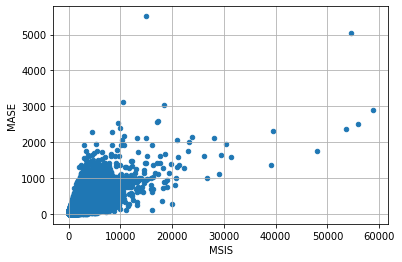

In [80]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Test metrics

# Conditioned Normalizing Flow